<img src="/work/Milestone-1-Project/ExecSummary.PNG">

___

**Code**

IF YOU ARE RUNNING THIS CODE LOCALLY INSTEAD OF DEEPNOTE THEN YOU WILL HAVE TO MANUALLY RUN FOLLOWING IN YOUR CODE'S CURRENT WORKING DIRECTORY

    pip install - r requirements.txt

In [1]:
!pip install -r requirements.txt

You should consider upgrading via the 'c:\users\fredg\anaconda3\python.exe -m pip install --upgrade pip' command.


  Using cached Pympler-0.9.tar.gz (178 kB)
  Created wheel for pympler: filename=Pympler-0.9-py3-none-any.whl size=164808 sha256=7e2ce83afbe357132302bcf8653501fe6e599fc205e7ef282501e03a88a44b60
  Stored in directory: c:\users\fredg\appdata\local\pip\cache\wheels\24\6f\0b\da9f81234859a8741aaea3afcc6ae2daf0efb67e7ff2d3686c
  Created wheel for blinker: filename=blinker-1.4-py3-none-any.whl size=13454 sha256=94f5b802db0ab3a355872df13a5d3ff2ff96d80dd0eb752ef1cefe007ff370c4
  Stored in directory: c:\users\fredg\appdata\local\pip\cache\wheels\b7\a5\68\fe632054a5eadd531c7a49d740c50eb6adfbeca822b4eab8d4
Successfully built pympler blinker


In [2]:
import matplotlib
%matplotlib inline
import os
import json
import pandas as pd
import numpy as np
import math
import folium
import altair as alt
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn import cluster
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from folium import IFrame
from numpy import linalg
import scipy
import branca.colormap as cm
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
# import altair_viewer
from PIL import Image
#!-m pip install --upgrade pip
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults,ARMA,ARMAResults
from sklearn.metrics import mean_squared_error
world_geo = r"world.json" # geojson file

# Data Preparation and Manipulation:

___


We have created separate python file to load primary and secondary datasets into individual dataframes and perform initial cleaning tasks. The M1_loaddata file can be found [here](https://deepnote.com/project/Fred-and-Ks-Milestone-1-project-TMDyVSD5Ta-IGSMNQkWm0Q/%2FMilestone-1-Project%2FM1_loaddata.py)

In [3]:
#Importing Main Dataset and Secondary Datasets

%run M1_loaddata

Primary Dataset exists, Let's go!
Loading datasets into dataframes......
Finished loading all datasets and creating respective dataframes


Now we will try to find our customer's order characteristics. To achieve that we are grouping our primary dataset by 'Customer ID'

In [4]:
#Grouping sales by customers
customer_df = clean_df.groupby(by=['Customer ID']).agg({'Quantity':['min', 'max', 'sum'], 'Price':['min', 'max', 'mean']})
print("Number of unique customers in our dataset = ", customer_df.index.size)

Number of unique customers in our dataset =  5853



___

The purpose of following function is to group each countries performance in the primary and secondary datasets, extract it in the form of a library which will be later used to form our Final DF that will used for further analysis tasks.  


In [5]:
# Function to get all the country related information for the analysis task
def countrydf(name, frequency="M"):
    # Country specific local dataframe
    cdf = clean_df.loc[clean_df["Country"] == name]
    # Datetime conversion
    cdf["date"] = pd.to_datetime(cdf.InvoiceDate)
    
    # Now lets find cummulative Sales for plot
    # First lets group by Date to get transaction total per day
    plotdf = cdf.set_index("date").resample(frequency)['SalesValue'].sum()
    
    # Convert series to dataframe
    plotdf = plotdf.reset_index()
    # Change date format from YYYY-MM-DD to YYYY-MM
    plotdf["date"] = plotdf["date"].dt.strftime("%Y-%m")
    # Set date as index
    plotdf = plotdf.set_index("date")
    
    # Total sales for the country
    sales = plotdf["SalesValue"].sum()
    # DF that conforms to 13 row format if frequency is set to monthly
    if frequency == "M":
        plotdf = (plotdf + dummydf).fillna(0)
    # Number of unique customers in the country
    custcnt = len(cdf["Customer ID"].unique())
    # Numpy array of unique stock sold in each country
    uniquestock = cdf["StockCode"].unique() #add .tolist() if list output is desired
    #Country code
    code = valeurs(name)
    #GDP, CPI,  for year 2011
    gdp = gdp_df.loc[gdp_df["Country Code"] == code, "2011"].item()
    cpi = cpi_df.loc[cpi_df["Country Code"] == code, "2011"].item()
    #exchrate = exchrate_df.loc[exchrate_df["Country Code"] == code, "2011"].item()
    pop = pop_df.loc[pop_df["Country Code"] == code, "2011"].item()
    merch = merch_df.loc[merch_df["Country Code"] == code, "2011"].item()
    internet = internet_df.loc[internet_df["Country Code"] == code, "2011"].item()
    #Sea Distance
    dist = seadist_df.loc[seadist_df["iso2"]==code, "seadistance"].item()
    #Country region
    region = prop_df.loc[prop_df["Country Code"] == code, "Region"].item()
    
    #Country region
    incgrp = prop_df.loc[prop_df["Country Code"] == code, "IncomeGroup"].item()
    #Life expectancy

    life_expect=lifeExpect_df.loc[lifeExpect_df["Country Code"] == code, "2011"].item()
    #Expenditure on health

    expend_health = expendHealth_df.loc[expendHealth_df["Country Code"] == code, "2011"].item()
    #PPP per capita
    ppp_capita = PPP_per_capita_df.loc[PPP_per_capita_df["Country Code"] == code, "2011"].item()
    
    return {'name':name, 'code':code, 'region': region, 'income group': incgrp, 'df':plotdf, 
            'totalsales':sales, 'customercnt':custcnt, 'uniqueStockID': uniquestock, 
            'gdp':gdp, 'cpi':cpi, 'population':pop, 'merchsales': merch, 'internet':internet, 
            'distance':dist, 'expend_health':expend_health,'ppp_cap':ppp_capita,
            'life_expect':life_expect }


# Creating dummydf to obtain fixed 25 row msales_df i.e. Monthly sales Dataframe
dummyindex = ['2009-12', '2010-01', '2010-02', '2010-03', '2010-04', '2010-05',
              '2010-06', '2010-07', '2010-08', '2010-09', '2010-10', '2010-11',
              '2010-12', '2011-01', '2011-02', '2011-03', '2011-04', '2011-05',
              '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11',
              '2011-12']
dummyvalues = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
dummydf = pd.DataFrame({'date':dummyindex, 'SalesValue':dummyvalues})
dummydf = dummydf.set_index('date')

The purpose of analysis is to improve performance of our business in the export markets. Following is the list of our export markets, extracted from the primary database. The lis does not include UK and Channel Islands as they are considered as the home market. 

In [6]:
# Creating Final DF that will be used for regression analysis
# Safe to ignore the SettingWithCopyWarning warning
countries = ['Australia','France', 'USA', 'Belgium', 'EIRE', 'Germany', 'Portugal', 'Japan', 'Denmark', 'Nigeria', \
    'Netherlands', 'Poland', 'Spain', 'Italy', 'Cyprus', 'Greece','Norway', 'Austria', 'Sweden', \
        'United Arab Emirates', 'Finland', 'Switzerland', 'Malta', 'Bahrain', 'Bermuda', 'Hong Kong', \
            'Singapore', 'Thailand', 'Israel', 'Lithuania', 'Lebanon', 'Korea', 'Brazil', 'Canada', 'Iceland', 'Czech Republic', 'Saudi Arabia', 'RSA']
# Creating list of dictionaries obtained using countrydf function
finallist = [countrydf(country) for country in countries]
# Creating Dataframe from that list
finaldf = pd.DataFrame(finallist)


<ipython-input-5-32bdc885db40>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf["date"] = pd.to_datetime(cdf.InvoiceDate)


In the following cell, we will perform further data manipulation tasks to frame data suitable for exploratory and prediction analysis. Here we are interested in capturing monthly sales for each country and its cummulative sales for the years 2010 and 2011.

In [7]:
# Monthly sales Dataframe

msales_df= pd.DataFrame(columns = dummyindex)
for country in countries:
    # Country code
    code = valeurs(country)
    msales_df = msales_df.append(
        finaldf.loc[finaldf["code"] == code, 'df'].item().T)

msales_df['name'] = countries
msales_df = msales_df.set_index('name')

# Yearly sales Dataframe
yr2010 = ['2010-01', '2010-02', '2010-03', '2010-04', '2010-05',
          '2010-06', '2010-07', '2010-08', '2010-09', '2010-10', '2010-11',
          '2010-12']
yr2011 = ['2011-01', '2011-02', '2011-03', '2011-04', '2011-05',
          '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11',
          '2011-12']
yr2012=['2012-01', '2012-02', '2012-03', '2012-04', '2012-05',
          '2012-06', '2012-07', '2012-08', '2012-09', '2012-10', '2012-11',
          '2012-12']

yrsales_df = pd.DataFrame(columns=['Sales 2010', 'Sales 2011'])
yrsales_df['Sales 2010'] = msales_df[yr2010].sum(axis=1)
yrsales_df['Sales 2011'] = msales_df[yr2011].sum(axis=1)

# Adding yearly sales information back to Final DF for analysis portion
finaldf['Sales_2010'] = yrsales_df.reset_index()['Sales 2010']
finaldf['Sales_2011'] = yrsales_df.reset_index()['Sales 2011']

## Our Final DF 



In [8]:
finaldf.to_excel("data_macro.xlsx")
finaldf.head(5)

name code                 region income group  \
0  Australia  AUS    East Asia & Pacific  High income   
1     France  FRA  Europe & Central Asia  High income   
2        USA  USA          North America  High income   
3    Belgium  BEL  Europe & Central Asia  High income   
4       EIRE  IRL  Europe & Central Asia  High income   

                                                  df  totalsales  customercnt  \
0           SalesValue
date               
2009-1...   168484.66           15   
1           SalesValue
date               
2009-1...   315261.67           93   
2           SalesValue
date               
2009-1...     7920.01            8   
3           SalesValue
date               
2009-1...    57322.77           29   
4           SalesValue
date               
2009-1...   591536.65            3   

                                       uniqueStockID           gdp  \
0  [22087, 85206A, 21895, 21896, 22083, 21871, 84...  1.015660e+12   
1  [22065, 22138, 22139, 22352, 85014A, 85014B, 1...  2.800855e+12   
2  [21268, 21412, 22083, 22084, 22086, 22085, 211...  1.706195e+13   
3  [22212, 79000, 20685, 82600, 21672, 21673, 223...  5.315359e+11   
4  [35751C, 72739B, 22114, 22212, 21523, 48187, 4...  2.464671e+11   

          cpi   population    merchsales   internet   distance  expend_health  \
0  103.303850   22340024.0  2.437010e+11  79.487698  20225.200       8.541520   
1  102.111598   65342789.0  7.200280e+11  77.819999   3224.950      11.203093   
2  103.156842  311583481.0  2.266024e+12  69.729461   7767.240      16.376293   
3  103.532082   11038264.0  4.669430e+11  81.609996    323.696      10.136656   
4  102.557189    4580084.0  6.660600e+10  74.889973    734.066      10.688899   

        ppp_cap  life_expect  Sales_2010  Sales_2011  
0  45830.119227    81.895122    31075.10   137138.46  
1  43069.330252    82.114634   134026.61   175361.37  
2  54884.707368    78.641463     4339.62     3580.39  
3  48193.266735    80.585366    21707.74    35327.43  
4  52991.855771    80.746341   325586.76   248782.68

___

# Visualizing macro factors and sales

## Correlation matrix

Now that we have our dataframe ready, let's explore what correlation can be found between our export market countries' macro-economic performance and its sales.

In [9]:
# Establishing factors list
liste_full=['Sales_2011','gdp', 'cpi', 'population', 'merchsales', 'internet', 'distance',
       'expend_health', 'ppp_cap', 'life_expect']
liste_factores=liste_full[1:]

In [10]:
# creating the correlation matrix for all factors including sales
corr=finaldf[liste_full].corr().round(2)
corr.sort_values(by="Sales_2011",ascending = False,inplace=True)  
sns.set_theme()

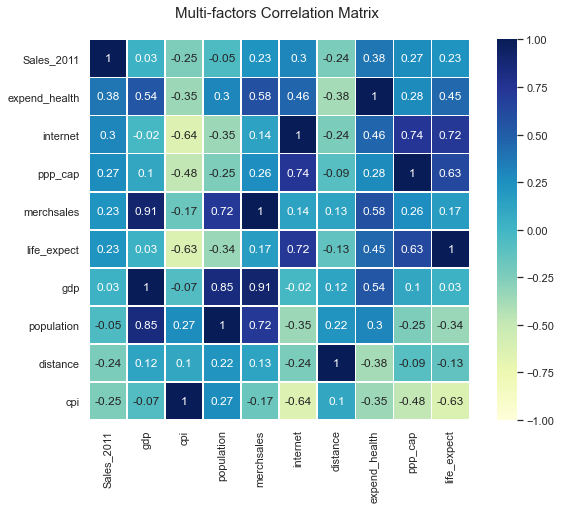

In [11]:
# plotting correlation matrices for limited
def matrix(title,size,corr,rang,square=True,annot=True):
    fig = plt.figure()
    fig.set_size_inches(size[0], size[1])

    ax1 = plt.subplot()
    ax1 = sns.heatmap(corr,vmin=rang[0], vmax=rang[1], cmap="YlGnBu"
    ,center=(rang[0]+rang[1])/2,square=square,annot=annot,linewidths=.8)
    ax1.set_title(title,fontsize=15)

matrix(title="Multi-factors Correlation Matrix \n",size=(10,7),corr=corr,rang=(-1,1))

# cmap="YlGnBu"
# cmap=sns.diverging_palette(20, 220, n=25)

## Folium map data preparation 

Now let's build an interactive map - with a menu of all the indicators. We wish to provide user to be able to visualize all variables from the final_df on geographical scale.  
These indicators have different measures, so we will standardize them in order to have consistency in the visualization.  
Merged_df_norm is our final, normalized dataset.  
*FOLIUM map code reference: Frederic Gigou SIADS 521 assignment 3*

In [12]:
# Now let's build an interactive map - with a menu of all the indicators.
# These indicators have different measures, so we will standardize them in order to have consistency in the visualization
# Merged_df_norm is our final, normalized dataset
# FOLIUM map code reference: Frederic Gigou SIADS 521 assignment 3

# preparing the data_set
merged_df3=finaldf.copy()
merged_df3.set_index("code",inplace=True)
df3=merged_df3[liste_full]
merged_df_norm = df3.apply(lambda x: (x - np.nanmean(x)) / np.nanstd(x))
df3.reset_index(inplace=True)
df3["Country"]=df3["code"].apply(lambda val:valeurs(val,value=False))
df1=df3
# renaming columns for map visualization
df1.columns=["code","2011 Sales $","GDP","CPI","Population", "Imports", "Internet penetration", "Distance", "Expenditure on Health", "PPP per Capita", "Life Expectancy", "Country"]

<ipython-input-12-3755971cc13e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["Country"]=df3["code"].apply(lambda val:valeurs(val,value=False))


In [13]:
# let's set a new folium map with a high-level zoom

new_map = folium.Map(location=[0, 0], zoom_start=1.5)

# Now we need to create feature groups with their corresponding data frames in order to draw the indicators on the map

data_frames=[]
liste_feat_groups=[]
liste_map=["2011 Sales $","GDP","CPI","Population", "Imports", "Internet penetration", "Distance", "Expenditure on Health", "PPP per Capita", "Life Expectancy"]

j=0
for element in liste_map:
    df="{}".format(element)
    df=df1[["Country","code",element]]
    data_frames.append(df)   
    feat_group="feature_group{}".format(j)
    feat_group = folium.FeatureGroup(name=element,overlay=False).add_to(new_map)
    liste_feat_groups.append(feat_group)
    j+=1

In [14]:
# let's incorporate  the  feature groups within the Choropeth object that's part of the map.
for i in range(len(data_frames)):
    
    choropleth = folium.Choropleth(
    geo_data=world_geo,
    name='choropleth',
    data=data_frames[i],
    columns=['code',liste_map[i]],
    key_on='feature.id',                     
    fill_color='YlGnBu',
    nan_fill_color="white",
    fill_opacity=0.7,
    line_opacity=0.2,
    highlight=True,
    legend_name=liste_full[i],   
    line_color='black').geojson.add_to(liste_feat_groups[i])
    
    # Let's add the country labels that are activated when the mouse
    geojson1 = folium.GeoJson(data=world_geo,style_function=lambda x: {'color':'black','fillColor':'transparent','weight':0.5}, tooltip=folium.GeoJsonTooltip(fields=['name'],labels=False)).add_to(choropleth)

# Let's add a legend to the map   
colormap = cm.linear.YlGnBu_09.scale(-3,3)
colormap = colormap.to_step(10)
colormap.caption = "Data is standardized"
colormap.add_to(new_map)

# Let's display the menu
folium.LayerControl(collapsed=False).add_to(new_map)


## Folium map visualization

In [15]:
# finally, let's draw the map, We are done!
new_map    

# You can now navigate on each country to see their country name and also use the menu on the right.

**Findings**:  
We hope this visualization will provide you with geographical perspective of our operational presence, along with each market’s macro economic performance for the year 2011. 
As we can see, we have a strong European presence. In addition, we have a growing geographic footprint with only a few scaled markets with yet untapped macro potential.   

**Our focus in 2012 should be  to unleash our existing markets’ potential.**
___


# EDA - Business Performance of Export Markets

In this section we wish to study the order patters of customers and of export market countries.  

We wish to analyze three sets of patters -   
  1. *Order Frequency* -      How often does a customer place an order or how often have we received an order from a particular country.
  2. *Order Recency* -        What was the period of most recent order placed by the customer or from the country of sale. 
  3. *Average Order Value* -  What was the category of average order value placed by a customer. We have 4 categories - a. £0-10, b. £10-100, c. £100-250, d. > £250

We are also interested in finding our retention performace. The retention performance is measured as follows -  
1. *Retained* -       If a customer or a country placed 1 or more orders in the year 2010 and 2011.
2. *New* -            If a customer or a country placed 1 or more orders for the very first time in the year 2011.
3. *Lost* -           If a customer or a country had one or more orders in the year 2009 or 2010, but did not place any new order in the year 2011.  

## Preparing Data

We have written custom functions to parse the data from Clean DF in the format suitable for the analysis task at hand. The details of each functions can be found [here](https://deepnote.com/project/Fred-and-Ks-Milestone-1-project-TMDyVSD5Ta-IGSMNQkWm0Q/%2FMilestone-1-Project%2Fedacustomfuncs.py)

In [16]:
# Loading custom functions created for EDA - 
%run edacustomfuncs.py

<Figure size 432x288 with 0 Axes>

Here we will employ custom EDA functions that we initialized in the previous step.  

We are generating two new dataframes for customer and country specific analysis. Sample for each is presented below. 

In [17]:
drop_countries = ['European Community','United Kingdom', 'Unspecified', 'West Indies', 'Channel Islands', 'Hong Kong', 'Bermuda']
indexNames = clean_df[clean_df['Country'].isin(drop_countries)].index
# Delete these row indexes from dataFrame
expmkt_df = clean_df.drop(indexNames)


customersummary = eda_df(expmkt_df, col_name='Customer ID')
print(customersummary.head(3).to_markdown())
print('\n')
countrysummary = eda_df(expmkt_df, col_name='Country')
print(countrysummary.head(3).to_markdown())

Created dataframe containing EDA by grouping on -  Customer ID
|    |   Customer ID |   TransactCount |   UniqueStockCount |   TransactAvg | AOV      | TransactFreq   | TransactRecency   | TransactYears   | Retaintion   |
|---:|--------------:|----------------:|-------------------:|--------------:|:---------|:---------------|:------------------|:----------------|:-------------|
|  0 |         12347 |             253 |                126 |       22.2661 | b.10-100 | 3.Every Year   | 1.This Week       | [2010, 2011]    | Retained     |
|  1 |         12348 |              46 |                 24 |       36.0522 | b.10-100 | 3.Every Year   | 4.This Year       | [2010, 2011]    | Retained     |
|  2 |         12349 |             172 |                137 |       21.3877 | b.10-100 | 3.Every Year   | 3.This Quarter    | [2010, 2011]    | Retained     |


Created dataframe containing EDA by grouping on -  Country
|    | Country   |   TransactCount |   UniqueCustomerCount |   TransactAvg | AOV 

## Analyzing Data

Let's look at the count of countries that we were able to retain, add and some that were unfortunately lost sales in the year 2011.

In [18]:
# cntsummarydf function returns the count or percentage of a column in a supplied DF
print(cntsummarydf(countrysummary, 'Retaintion', perc=False).to_markdown())

| Retaintion   |   Retaintion |
|:-------------|-------------:|
| Lost         |            4 |
| New          |            3 |
| Retained     |           29 |


Similary now let's look at the count of customers that we were able to retain, add and some that were unfortunately lost sales in the year 2011.

In [19]:
# cntsummarydf function returns the count or percentage of a column in a supplied DF
print(cntsummarydf(customersummary, 'Retaintion', perc=False).to_markdown())

| Retaintion   |   Retaintion |
|:-------------|-------------:|
| Lost         |          104 |
| New          |          175 |
| Retained     |          218 |


For our analysis we are also interested in exploring order frequency, recency and avg. order value trends of our customers and of our export markets.

In [20]:
# cntsummarydf function returns the count or percentage of a column in a supplied DF
# For this step we are interested in finding %

# First we will find frequency 
frq = cntsummarydf(customersummary, 'TransactFreq', perc=True)
print(frq)

#Recency
rec = cntsummarydf(customersummary, 'TransactRecency', perc=True)
print(rec)

#Average Order Value (AOV)
aoval = cntsummarydf(customersummary, 'AOV', perc=True)
print(aoval)


TransactFreq
1.Every Week      0.201207
2.Every Month     1.609658
3.Every Year     36.619718
4.No Pattern     61.569416
Name: TransactFreq, dtype: float64
TransactRecency
1.This Week         7.444668
2.This Month        3.420523
3.This Quarter     36.820926
4.This Year        31.388330
5.Last Year        20.321932
6.Lost Customer     0.603622
Name: TransactRecency, dtype: float64
AOV
a.1-10        3.822938
b.10-100     91.750503
c.100-250     3.018109
d. >250       1.408451
Name: AOV, dtype: float64


## Plotting Data

Let's now visualize the results of the above analysis.

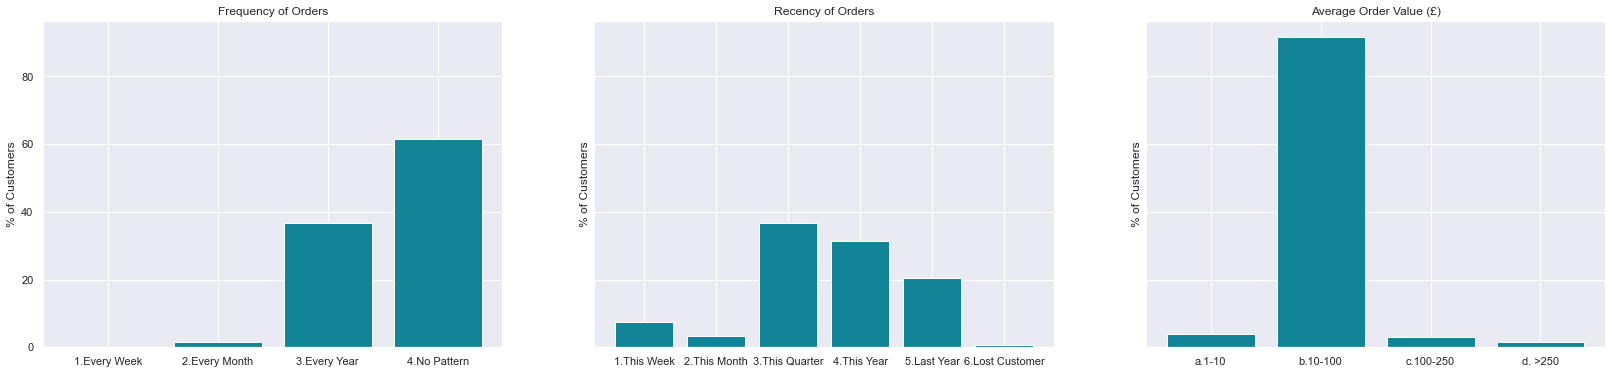

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(28, 6), sharey=True)
axs[0].bar(frq.index, frq.values, color='#118497')
axs[0].set_title("Frequency of Orders")
axs[1].bar(rec.index, rec.values, color='#118497')
axs[1].set_title("Recency of Orders")
axs[2].bar(aoval.index, aoval.values, color='#118497')
axs[2].set_title("Average Order Value (£)")

for ax in axs.flat:
    ax.set(ylabel='% of Customers')

**EDA CONCLUSION**  
Considering difference between numbers of new and lost customers, and number of countries where we did not record any new sales in the year 2011 – we must actively look at strategies to improve vertical expansion such as more average order value, customer retention and frequency of transactions.  

**1. Focus on Key Markets. (Where to play?)**  
**2. Improve stock portfolio recommendations to customers (How to Win?)**  

_____
_____
_____


Our first business question was: what 5 countries offer the most sales potential out of our current exports markets? We addressed the problem by formulating the analytical question: Is there a relationship between our value sales and key macro indicators? And can we predict sales potential based on macro data?

We fitted an ordinary linear regression model (OLS) between 2011 value sales (dependent variable) and countries’ key indicators. We optimized our model by running all combinations of these indicators and picking the one with the highest adjusted R squared. Steps for which are shown below.



# Fitting regression model sales ~ macro data

## Finding optimal model based on adjusted R2

In [22]:
# Fitting the macro model

def macro_model(liste_factores,finaldf):
    dico={}
    r=0
    winner=[]

    for i in range(1,len(liste_factores)):
        # Creating an itertool object with all combinations of factors
        liste=(itertools.combinations(liste_factores,i))
        winner_liste=["Sales_2011"]
    
        for i in liste:
            # Creating a string with + to integrate factors into model
            element1=' + '.join(list(i))
            winner_liste.append(i)
        
        
            # Creating string with final parameters for linear regression
            a="Sales_2011 ~ {}".format(element1)
        
            # Running the linear regression
            model = sm.OLS.from_formula(a, data=finaldf)
            result = model.fit()
        
            # Creating a dictionary with all the combinations' adj r squared results
            dico[element1]=result.rsquared_adj.round(3)
            r1=dico[element1]
        
            # saves best adjusted r-squared and liste of columns 
            if r1>r:
                r=r1
                winner=element1

    # Build liste from winning string
    winner_liste=winner.split(" + ")
        
    # Extracting second best model
    second=sorted(dico.items(), key=lambda x: x[1],reverse=True)[:5][1][0]

    # Running the winning model
    a="Sales_2011 ~ {}".format(winner)
    model = sm.OLS.from_formula(a, data=finaldf)
    result = model.fit()

    # Returns best model according to Adjusted R-squared
    return result,winner_liste,dico

# Returns best model according to Adjusted R-squared
result,winner_liste,dico=macro_model(liste_factores,finaldf)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Sales_2011   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     7.162
Date:                Sun, 21 Nov 2021   Prob (F-statistic):           0.000822
Time:                        19:29:48   Log-Likelihood:                -443.92
No. Observations:                  36   AIC:                             895.8
Df Residuals:                      32   BIC:                             902.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -5.842e+04   3.27e+04     -1.786      0.084   -1.25e+05    8211.540
gdp           -3.212e-08   8.62e-09     -3.726      0.001   -4.97e-08   -1.46e-08
merchsales     2.007e-07   5.97e-08      3.361      0.002    7.91e-08    3.22e-07
expend_health  9794.4545   4262.092      2.298      0.028    1112.857    1.85e+04
==============================================================================
Omnibus:                       23.171   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.087
Skew:                           1.716   Prob(JB):                     8.84e-09
Kurtosis:                       6.599   Cond. No.                     1.10e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Pairplots of winning model factors

C:\Users\fredg\anaconda3\lib\site-packages\seaborn\axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


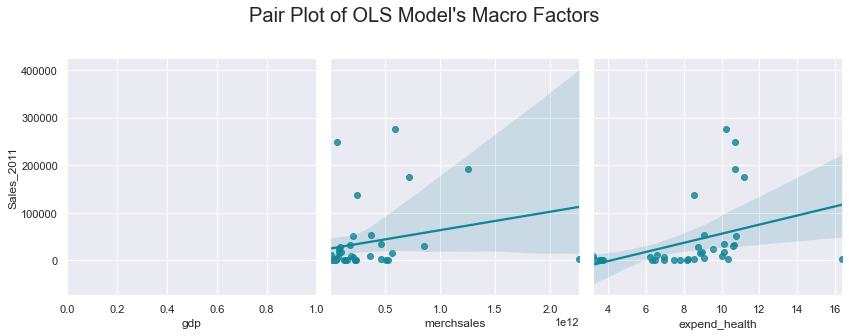

In [23]:
# Pair plot for winner_liste of factors
def pairplot(winner_liste):
    sns.pairplot(finaldf, 
             y_vars =["Sales_2011"],
             x_vars=winner_liste, 
             # hue = 'income group',
             kind = 'reg', 
             plot_kws=dict(color="#118497"),
             # plot_kws=dict(s=80,edgecolor="white", linewidth=2.5),
             size=4);
    # color="#BF9000"
    plt.suptitle("Pair Plot of OLS Model's Macro Factors", size=20, y=1.15);

pairplot(winner_liste)

## Top 10 macro models

In [24]:
# Returns Top 10 models according to adjusted R-squared
ordered_liste=sorted(dico.items(), key=lambda x: x[1],reverse=True)[:10]
second=ordered_liste[1][0]
ordered_liste

[('gdp + merchsales + expend_health', 0.346),
 ('gdp + population + merchsales + expend_health', 0.338),
 ('gdp + merchsales + expend_health + life_expect', 0.334),
 ('gdp + merchsales + internet + expend_health', 0.329),
 ('gdp + population + merchsales + expend_health + ppp_cap', 0.328),
 ('gdp + cpi + merchsales + expend_health', 0.326),
 ('gdp + merchsales + distance + expend_health', 0.325),
 ('gdp + merchsales + expend_health + ppp_cap', 0.325),
 ('gdp + merchsales + expend_health + ppp_cap + life_expect', 0.32),
 ('gdp + population + merchsales + distance + expend_health', 0.317)]

## Predictions based on winning macro model

In [25]:
# returning sales predictions dataset based on winning model
da=finaldf.copy()

predictions=result.predict(da)
da["Pred_macro"]=predictions

# converting negative values to 0
da.loc[da["Pred_macro"]<0,"Pred_macro"]=0

# Calculating macro potential as Sales_2011 minus the prediction
da.loc[:,'Potential_macro']=da.loc[:,'Pred_macro']-da.loc[:,'Sales_2011']
df_predict=da[['name','Sales_2010','Sales_2011','Pred_macro','Potential_macro']].copy()
df_predict.set_index("name",inplace=True)

# fill na to o
df_predict=df_predict.fillna(0)
df_predict.loc[:,"Potential_macro"]=df_predict.loc[:,"Potential_macro"].fillna(0)
df_predict.loc[df_predict["Potential_macro"]<0,"Potential_macro"] =0

# sort in descending order according to potentail
df_predict.sort_values('Potential_macro',ascending=False,inplace=True)

# returns df predict as integer
df_predict=df_predict.astype(int)

# returning data frame with predictions and potential
df_predict.head()

Sales_2010  Sales_2011  Pred_macro  Potential_macro
name                                                        
Canada         1216        3115       85502            82386
Belgium       21707       35327      117524            82197
Austria        9793        8585       63894            55308
Korea          1118           0       51731            51731
Italy         13731       15169       58464            43294

**Results and Interpretation**  
The winning model includes three variables: GDP, expenditure on health and imports. The F test, which tells if a group of variables are jointly significant (3), indicates a probability of 0.000822, which means, with alpha=0.05, that there’s a statistical significance.   
However, although literature shows diverse views, a low adjusted r-squared of 0.346 entails more errors and warns of inaccurate predictions  
(How To Interpret R-squared in Regression Analysis – Statistics By Jim Frosthttps://statisticsbyjim.com/regression/interpret-r-squared-regression)  
___

# Fitting regression model based on sales trend

## Monthly sales visualization

Before we go and perform linear regression on monthly sales for each country to predict sales for the year 2012, let's look at the monthly sales data from our primary dataset.

In [26]:
# Preparing dataset with sales by month
msales_df=msales_df.astype(int)
msales_df["sum"]=msales_df.sum(axis=1)
msales_df.sort_values("sum",ascending=False,inplace=True)
msales_df.drop('sum',axis='columns', inplace=True)
try:
    msales_df.drop('count',axis='columns', inplace=True)
except:
    pass


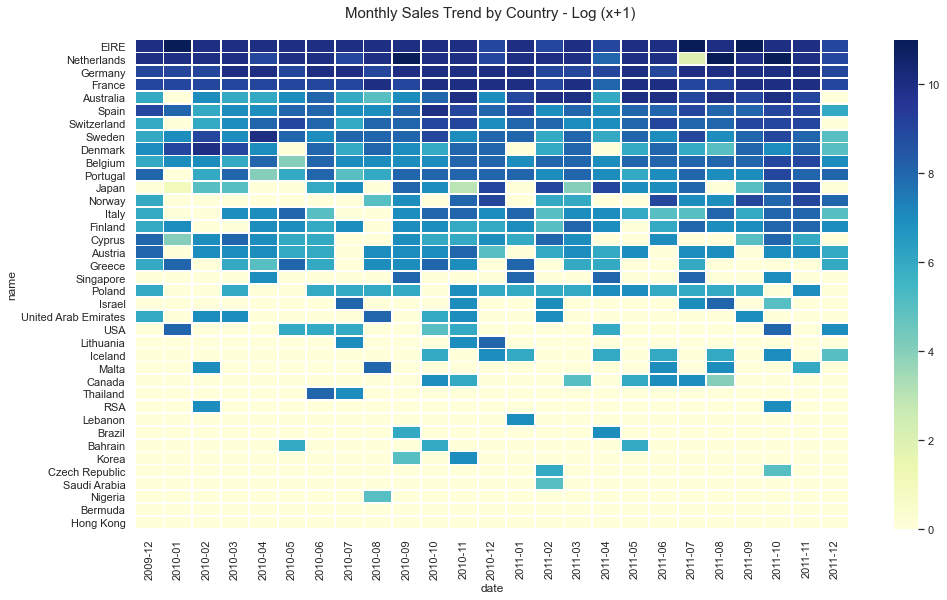

In [27]:
# Monthly Sales visualization with heat map
# Transformation to log (x+1) as we have many 0s in the dataset
def monthly_sales_log(msales_df):
    corr2=np.log(msales_df+1).round(0)
    maxi=corr2.to_numpy().max()

    matrix(title="Monthly Sales Trend by Country - Log (x+1) \n",size=(16,9),corr=corr2,rang=(0,maxi),
    square=False,annot=False)
monthly_sales_log(msales_df)

In [28]:
## add a count of existing sales value, will only make predictions on rows with at least 12 values.
msales_df['count'] = msales_df[msales_df > 0].count(axis=1)

# set the threshold for accepting projections
n=20

table_short=msales_df[msales_df['count']>=n].copy()
table_short.drop('count',axis='columns', inplace=True)

# convert negative values to zero
table_short[table_short < 0] = 0
table_short=table_short.astype(int)
liste_short=table_short.index
liste_short
n_country=len(table_short)
print('We have {} key export markets where we have recorded sales in 20 months out of 25.'.format(n_country))


We have 14 key export markets where we have recorded sales in 20 months out of 25.


In [29]:
### add a total for 14 key exports market to fit the model and run visualization.
table_short.loc['Total',:]= table_short.sum(axis=0)

Following plot shows sales trends of our company performance and its seasonal nature.

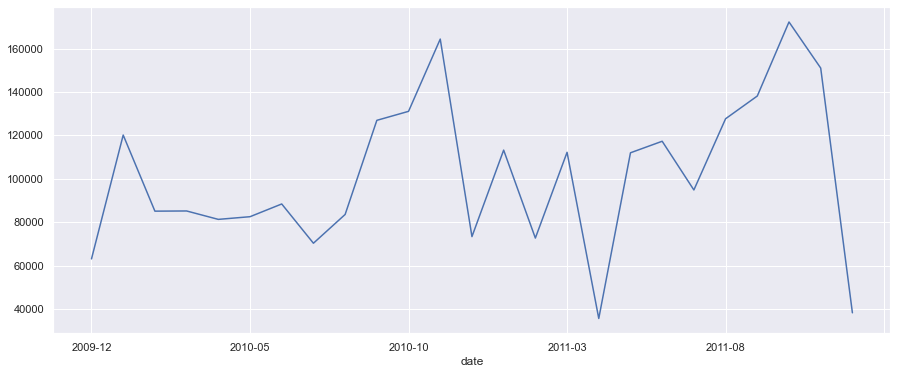

In [30]:
#Total sum per column: 

def plot_1(y):
    y.plot(figsize=(15, 6))
    plt.show()

y=table_short.loc['Total',:]
plot_1(y)

___  

We will be using past sales to forecast 2012 sales as we have 25 months of history. Although there’s no golden rule, at least 12 months of continuous sales are recommended to identify trends (1). However, out of 38 countries analyzed, 24 have incomplete sales data. Therefore, we only applied the model to the 14 entities with at least 20 months of sales.  

(1) How Much Data is Needed to Train a (Good) Model? | DataRobot, By Ryan Sevey, August 4, 2017

## 2012 Sales Linear regression monthly prediction function

In [31]:
## run linear prediction for 2012 for 14 countries with at least 20 readings)
def regression(row):
    my_x=list(range(1,len(row)+1))
    my_y=row
    b1, b0, r_value, p_value, std_err = scipy.stats.linregress(my_x, my_y)

    y_hat=[]
    for x in range (26,38):
        y_hat.append(b0 + b1 * x)
    
    return y_hat


table_short["month"]=table_short.apply(lambda row: regression(row.tolist()),axis=1)
table = pd.DataFrame([pd.Series(x).astype(int) for x in table_short.month],index=table_short.index)
table.columns=yr2012
table_short.drop('month',axis='columns', inplace=True)
table["Pred_regr"]=table.sum(axis=1).astype(int)
table[table < 0] = 0
table_short=pd.merge(table_short.reset_index(), table.reset_index(), how='left',left_on='name', right_on='name')

# Returning monthly sales projection
table_short.set_index('name',inplace=True)

In [32]:
# shows first 5 rows of monthly sales data including 2012 projections based on regression model.
table_short.head()

2009-12  2010-01  2010-02  2010-03  2010-04  2010-05  2010-06  \
name                                                                         
EIRE         17167.0  58669.0  19082.0  21778.0  20096.0  18028.0  22449.0   
Netherlands  15045.0  29167.0  17210.0  24241.0   6336.0  22221.0  24134.0   
Germany       9034.0  11260.0   7971.0  15347.0  21667.0   8100.0  14383.0   
France        5873.0   7316.0   8073.0   8027.0   6907.0  13344.0   8439.0   
Australia      271.0      0.0   1029.0    429.0    630.0   1312.0   3214.0   

             2010-07  2010-08  2010-09  ...  2012-04  2012-05  2012-06  \
name                                    ...                              
EIRE         31587.0  22419.0  35313.0  ...    19012    18721    18431   
Netherlands   5385.0  24881.0  44773.0  ...    25364    25575    25785   
Germany      18227.0   8982.0  16192.0  ...    19563    19813    20064   
France        7137.0  16285.0  12314.0  ...    19594    20030    20467   
Australia      631.0    176.0    785.0  ...    15865    16435    17006   

             2012-07  2012-08  2012-09  2012-10  2012-11  2012-12  Pred_regr  
name                                                                          
EIRE           18140    17850    17559    17268    16978    16687     219424  
Netherlands    25996    26206    26417    26627    26838    27048     310686  
Germany        20315    20565    20816    21067    21317    21568     242272  
France         20903    21340    21776    22213    22649    23086     248220  
Australia      17576    18147    18717    19287    19858    20428     207492  

[5 rows x 38 columns]

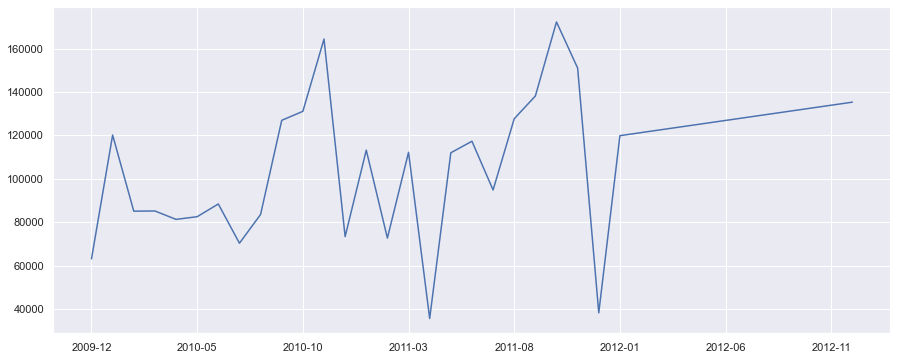

In [33]:
## visualizing sales projections for sum of 14 countries
y1=table_short.loc['Total'].iloc[:-1]
plot_1(y1)

___  

Now let's look at an alternative approach - SARIMA

## 2012 Sarima regression optimization

In [34]:
# Sarima function 
# Not seasonal but autoregressive (dependent on last value)
# p (AR) autorigressive, autocorrelation function (ACF) spikes decays to zero.
# q (MA) moving average, partial autocorrelation function (PACF) spikes decays to zero
# d (I) 1 means non stationary model
# SARIMAX= ARIMA with Seasonality and X exogeneous factors
# SARIMA= SARIMA without X (exog)

## Auto_arima code snipet reference: 
## Towards Data Science Time Series predictions using Arima & Sarimax Sailaja Karra Oct 20, 2020·

Sarimax_model = auto_arima(y,
                       start_P=1,
                       start_q=1,
                       max_p=3,
                       max_q=3,
                       m=12,
                       seasonal=True,
                       d=None,
                       D=1,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)


model = SARIMAX(y,order=Sarimax_model.order,
              seasonal_order=Sarimax_model.seasonal_order,
              enforce_stationarity=False,
              enforce_invertibility=False)
results = model.fit()
results.summary()


Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=306.590, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=310.580, Time=0.03 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=311.204, Time=0.04 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=306.084, Time=0.01 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=308.522, Time=0.02 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=308.507, Time=0.02 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=308.629, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=309.258, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=310.953, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12]          
Total fit time: 0.600 seconds


C:\Users\fredg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\fredg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                    Total   No. Observations:                   25
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -140.861
Date:                  Sun, 21 Nov 2021   AIC                            283.722
Time:                          19:29:50   BIC                            284.207
Sample:                      12-01-2009   HQIC                           283.543
                           - 12-01-2011                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.469e+08   3.32e+08      1.950      0.051   -3.25e+06     1.3e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.02
Prob(Q):                              0.87   Prob(JB):                         0.60
Heteroskedasticity (H):               1.07   Skew:                            -0.48
Prob(H) (two-sided):                  0.95   Kurtosis:                         1.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
print("Winning Sarima model is p,d,q {} and P,D,Q, months {}".format(Sarimax_model.order,Sarimax_model.seasonal_order))

Winning Sarima model is p,d,q (0, 0, 0) and P,D,Q, months (0, 1, 0, 12)


## Sales prediction visualization

In [36]:
element1=", ".join(['2010-01', '2010-02', '2010-03', '2010-04', '2010-05',
          '2010-06', '2010-07', '2010-08', '2010-09', '2010-10', '2010-11',
          '2010-12','2011-01', '2011-02', '2011-03', '2011-04', '2011-05',
          '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11',
          '2011-12'])

### Sarima model data prep

In [37]:
## creating a Nan prediction data set

# Creating the full index in month / date format
history_index=['2009-12','2010-01', '2010-02', '2010-03', '2010-04', '2010-05',
          '2010-06', '2010-07', '2010-08', '2010-09', '2010-10', '2010-11',
          '2010-12','2011-01', '2011-02', '2011-03', '2011-04', '2011-05',
          '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11',
          '2011-12']

# creating the correct prediction index in month/date format
predict_index=['2011-12','2012-01', '2012-02', '2012-03', '2012-04', '2012-05',
          '2012-06', '2012-07', '2012-08', '2012-09', '2012-10', '2012-11',
          '2012-12']

predict_index2=['2010-12','2011-01', '2011-02', '2011-03', '2011-04', '2011-05',
          '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11',
          '2011-12','2012-01', '2012-02', '2012-03', '2012-04', '2012-05',
          '2012-06', '2012-07', '2012-08', '2012-09', '2012-10', '2012-11',
          '2012-12']


full_index=['2009-12','2010-01', '2010-02', '2010-03', '2010-04', '2010-05',
          '2010-06', '2010-07', '2010-08', '2010-09', '2010-10', '2010-11',
          '2010-12','2011-01', '2011-02', '2011-03', '2011-04', '2011-05',
          '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11',
          '2011-12','2012-01', '2012-02', '2012-03', '2012-04', '2012-05',
          '2012-06', '2012-07', '2012-08', '2012-09', '2012-10', '2012-11',
          '2012-12']


def prediction_df(y,results):
    Sarimax_pred=pd.DataFrame(index=full_index,columns=["Sales"])

    Sarimax_pred["Sales"]=y
    pred= results.predict('2010-12','2012-12', dynamic= True)
    pred.index=predict_index2

    Sarimax_pred=pd.merge(Sarimax_pred, pred, how='left',left_index=True, right_index=True)

    ## extracting the confidence intervals
    pred = results.get_prediction('2010-12','2012-12', dynamic=False)
    pred_ci = pred.conf_int()
    pred_ci.index=predict_index2
    Sarimax_pred=pd.merge(Sarimax_pred, pred_ci, how='left',left_index=True, right_index=True)
    return Sarimax_pred

Sarimax_pred=prediction_df(y,results)

### Sarima visualization

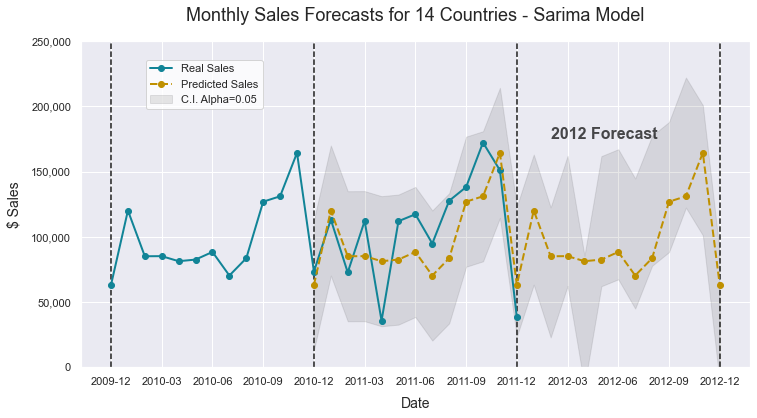

In [38]:
# Visualization function of model
def chart_predict(Sarimax_pred,name="Sarimax",ymin=0,ymax=250000):
    
    fig, ax=plt.subplots()
    fig.set_size_inches(12, 6) 
        
    # plotting both lines  
    ax.plot(Sarimax_pred['Sales'].index, Sarimax_pred['Sales'].values,linewidth=2, markersize=6,marker='o', color="#118497", label="Real Sales")
    ax.plot(Sarimax_pred["predicted_mean"].index, Sarimax_pred["predicted_mean"].values, linestyle='dashed',color="#BF9000",linewidth=2, markersize=6,marker='o', label="Predicted Sales")

    ## plotting the CI
    ax.fill_between(Sarimax_pred.index,Sarimax_pred['lower Total'],Sarimax_pred['upper Total'], color='k', alpha=.1,label="C.I. Alpha=0.05")
        
    ax.set_xlabel('Date',labelpad=10,size=14)
    ax.set_ylabel('$ Sales',labelpad=10,size=14 )
    ax.set_ylim(ymin, ymax)

    ax.set_title("Monthly Sales Forecasts for {} Countries - {} Model".format(n_country,name),fontsize=18,pad=20)

    ## draw year vertical lines
    # ymin=0
    ax.vlines('2009-12', ymin, ymax, colors='k', linestyles='--')
    ax.vlines('2010-12', ymin, ymax, colors='k', linestyles='--')
    ax.vlines('2011-12', ymin, ymax, colors='k', linestyles='--')
    ax.vlines('2012-12', ymin, ymax, colors='k', linestyles='--')
    ax.legend(bbox_to_anchor=(0.28,0.96),facecolor="white")

    # convert y axis to thousand separator
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

    # x axis= only 1/3 of labels
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(3))

    # make annotation
    ax.annotate("2012 Forecast", xy=(Sarimax_pred['Sales'].index[26], 175000),size=16,weight='bold',color="black",alpha=0.7)


    plt.show()
chart_predict.n_country=n_country
chart_predict(Sarimax_pred,name="Sarima")


As shown in the figure above, SARIMA model is considering the seasonal nature of our business. However, while visual observation shows a better monthly fit and a lower RMSE of 27,707, it lacks sufficient sales history. In fact, the statistical reference indicates that 50 to 100 observations are required for SARIMA to be valid (1). 

(1) Box and Tiao. 1975; Abraham 1980


### OLS model data prep

In [39]:
def prediction_df_OLS(y):
    OLS_pred=pd.DataFrame(index=history_index,columns=["Sales"])
    OLS_2=pd.DataFrame(index=full_index,columns=["Sales"])
    OLS_pred["Sales"]=y
    OLS_pred["x"]=range(1,len(OLS_pred)+1)
    OLS_2["Sales"]=y
    OLS_2["x"]=range(1,len(OLS_2)+1)
       
    model = sm.OLS.from_formula("Sales ~ x", data=OLS_pred)
    result = model.fit()
    # OLS_pred=pd.merge(OLS_2, OLS_pred,how='left',left_index=True, right_index=True)
    
    pred = result.get_prediction(OLS_2)
 

    predict_frame=pred.summary_frame(alpha=0.05)[["mean","mean_ci_lower","mean_ci_upper"]].astype(int)
    predict_frame.index=full_index
    predict_frame.columns=(["predicted_mean","lower Total","upper Total"])

    OLS_2=pd.merge(OLS_2, predict_frame,how='left',left_index=True, right_index=True)
    OLS_2.drop(["x"], axis=1,inplace=True)

    return result, OLS_2

result, OLS_2=prediction_df_OLS(y)
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     2.134
Date:                Sun, 21 Nov 2021   Prob (F-statistic):              0.158
Time:                        19:29:51   Log-Likelihood:                -295.74
No. Observations:                  25   AIC:                             595.5
Df Residuals:                      23   BIC:                             597.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    8.34e+04   1.43e+04      5.841      0.000    5.39e+04    1.13e+05
x           1403.1592    960.515      1.461      0.158    -583.817    3390.135
==============================================================================
Omnibus:                        1.848   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.397   Jarque-Bera (JB):                0.801
Skew:                          -0.402   Prob(JB):                        0.670
Kurtosis:                       3.350   Cond. No.                         30.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### OLS visualization - 14 aggregated countries

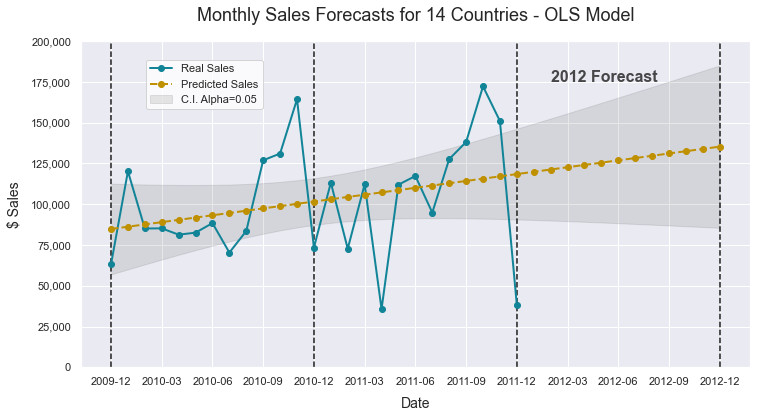

In [40]:
chart_predict(OLS_2,name="OLS", ymin=0,ymax=200000)

Figure shows sales regression for countries with sales history. Analysis and observation show that the model offers a wide CI and a RMSE of 33,217.  Nonetheless, it effectively captures the sales trend on a full year basis, which is our primary objective for estimating potential. Consequently, we chose this model and applied the same technique for all countries with good sales history. 

### Comparative RMSE, Sarima vs OLS

In [41]:
df2=pd.concat([OLS_2,Sarimax_pred],axis=1)
df2.to_excel("forecasts.xlsx")

In [42]:
## Calculates RMSE for both models
def RMSE(df):
    error=mean_squared_error(df.Sales, df.predicted_mean)
    RMSE=int(np.sqrt(error))
    return RMSE

print("SARIMA RMSE: {}".format(RMSE(Sarimax_pred.iloc[12:25,:2])))
print("OLS RMSE: {}".format(RMSE(OLS_2.iloc[:25,:2])))

SARIMA RMSE: 27707
OLS RMSE: 33217


Now that we have chosen our Model, let's deploy it to rank countries in order to find where to play?

___

# Where to Play : Country Ranking

## Data preparation: country ranking

In [43]:
## returning a summary table with Sales history, prediction and potential for all countries.
merged_potential=pd.merge(df_predict.reset_index(), table_short['Pred_regr'].reset_index(), how='left',left_on='name', right_on='name')
merged_potential.round(0)
merged_potential["Potential_regr"]=merged_potential['Pred_regr']-merged_potential["Sales_2011"]
# merged_potential=merged_potential[[]]
merged_potential=merged_potential.fillna(0)
merged_potential.set_index("name",inplace=True)
merged_potential[merged_potential < 0] = 0
merged_potential=merged_potential.astype(int)
liste_top_n=merged_potential.sort_values("Potential_regr",ascending=False).head(5).index
liste_top_n
cols=['2010 Sales', '2011 Sales', 'Macro Reg', 'Macro Reg_pot','2012 Reg','2012 Reg_pot']
merged_potential.columns=cols


In [44]:
## data preparation function, will rank the data, filter top N countries and return a melted df for Altair visualization
top=5
pd.options.mode.chained_assignment = None  

## return data set and country rank for visualization depending on order parameter
def data_prep_vis(merged_potential,order='2012 Reg_pot',TOP=5):
    merged_potential.sort_values(order,ascending=False,inplace=True)
      
    # filters top_n countries for visualizaiton 
    merged_potential=merged_potential.head(TOP)
    key_markets=merged_potential.index

    # Create a label with rank number and country name
    merged_potential["Rank"] = merged_potential[order].rank(ascending=False)
    merged_potential.reset_index(inplace=True)
    merged_potential.rename(columns = {'name': 'market'},inplace=True)
    def f(a,b):
        return (str(int(a))+"- "+str(b))
    
    merged_potential["Country"]=merged_potential.apply(lambda x:f(x.Rank, x.market), axis=1)

    # Removes non necessary rows for visualization
    merged_potential.drop(['Rank','market'],axis='columns', inplace=True)

    merged_potential.reset_index(inplace=True)
    
    # Melts data frame for Altair visualization formating. Rename columns and format labels
    df_melted = pd.melt(merged_potential, id_vars=["Country"], value_vars=cols)
    df_melted.columns=["Country","Year","$ Sales"]
    merged_potential.drop('index',axis='columns', inplace=True)
    liste_country=df_melted.Country.unique()
    df_melted["label"]=df_melted["$ Sales"].apply(lambda x: str(int(x/1000))+" K")
    
    return key_markets,df_melted,liste_country

data_prep_vis.cols=cols


**Here are our Top 5 countries ordered according to their 2012 Potential Sales Growth.**

In [45]:
# returning data set first 5 rows for rendering 
key_markets,df_melted,liste_country=(data_prep_vis(merged_potential,order='2012 Reg_pot',TOP=top))
df_melted.head()

Country        Year  $ Sales  label
0       1- France  2010 Sales   134026  134 K
1    2- Australia  2010 Sales    31075   31 K
2      3- Germany  2010 Sales   187504  187 K
3  4- Netherlands  2010 Sales   259772  259 K
4  5- Switzerland  2010 Sales    41937   41 K

**Let's visualize our top 5 markets according to their 2012 Sales Growth Potential!**

In [46]:
# Visualization function of sales potential

def bar(country,ax):

    # Filters column from for loop
    df=df_melted[df_melted["Country"]==country]
    
    # determines a specific color hex code for each label
    color_scale = alt.Scale(domain=['2010 Sales', '2011 Sales','2012 Reg','2012 Reg_pot','Macro Reg', 'Macro Reg_pot'],
                        range=["#E7BC29","#BF9000","#118497","#118497","#809EC2","#809EC2"])

    # Returns first horizontal chart with y axis label
    if ax:
        chart=alt.Chart(df).mark_bar(size=20,fontSize=16).encode(
            x=alt.X('$ Sales:Q',title=country,scale=alt.Scale(domain=[0,450000]),axis=None),
            y=alt.Y('Year:N',axis=alt.Axis(labelFontSize=16,labelPadding=15,title=None,grid=False)),
            color=alt.Color('Year:N'))

    # returns charts 2 to 5 without y label
    else:
        chart=alt.Chart(df).mark_bar(size=20,fontSize=16).encode(
            x=alt.X('$ Sales:Q',title=country,scale=alt.Scale(domain=[0,450000]),axis=None),
            y=alt.Y('Year:N',title=None,axis=None),            
            color=alt.Color('Year:N',scale=color_scale,legend=None)) #, scale=color_scale,legend=None)

    # Add text lable
    text = alt.Chart(df).mark_text(size=12,dx=25,dy=0,fontWeight=200).encode(y=alt.Y('Year:N'),x=alt.X('$ Sales:Q'),
                                                                             text=alt.Text('label:N'))
    
    return text + chart

# format final chart with size / strokeWidth and padding (meaning bar space) and add title
def configuration(chart,title,subtitle):
    chart_final = chart.configure_mark().properties(
        title=alt.TitleParams(text=title,fontSize=20)).configure_view(
        strokeWidth=0).configure_scale(
        bandPaddingInner=0.2)
    return chart_final

# assign df_melted to function
bar.df_melted=df_melted
  


## Economic potential visualization based on sales regression

In [47]:
# Loop through all countries to render the layered chart with 5 countries overall.

ax=True
for country in liste_country:
    if ax:
        plot1=bar(country,ax).properties(
            width=90,height=130,title=alt.TitleParams(text=country,fontSize=14,dy=-5))
    else:
        plot1=plot1 | bar(country,ax).properties(
            width=90,height=130,title=alt.TitleParams(text=country,fontSize=14,dy=-5))
    ax=False

# rendering was disabled due to Altair bug in deepnote. Code renders in 
plot1.properties(title=alt.TitleParams(text="Figure 5: Economic Net Potential Summary",fontSize=18,dy=-5))   

alt.HConcatChart(...)

## 

___

Alternatively, if we were to consider using MacroEconomic Indicator based potential determination model, then the ranking and its visualization would look like following - 

## Visualization of  Macro potential

In [48]:
# preparing dataset with macro potential
liste_potential,df_melted,liste_country=(data_prep_vis(merged_potential,order='Macro Reg_pot',TOP=top))
print(liste_country)
print(df_melted.head())

['1- Canada' '2- Belgium' '3- Austria' '4- Korea' '5- Italy']
      Country        Year  $ Sales label
0   1- Canada  2010 Sales     1216   1 K
1  2- Belgium  2010 Sales    21707  21 K
2  3- Austria  2010 Sales     9793   9 K
3    4- Korea  2010 Sales     1118   1 K
4    5- Italy  2010 Sales    13731  13 K


In [49]:
# Renders chart with top 5 countries with macro potential

ax=True
for country in liste_country:
    if ax:
        plot1=bar(country,ax).properties(width=90,height=130,title=alt.TitleParams(text=country,fontSize=14,dy=-5))
    else:
        plot1=plot1 | bar(country,ax).properties(width=90,height=130,title=alt.TitleParams(text=country,fontSize=14,dy=-5))
    ax=False

plot1.properties(title=alt.TitleParams(text="Economic Net Potential Summary",fontSize=18,dy=-5))



alt.HConcatChart(...)

## Bubble chart visualization of key and potential markets

In [50]:
## preparing source data set to visualize key and potential markets in a bubble chart

def type_country(x):
    if x in liste_top_n:
        x="Key markets"
    elif x in liste_potential:
        x="Potential markets"
    else:
        x="Other"
    return x

# Establishing groups for "color" hue and only keep key and potential markets
source=merged_potential.copy()
source.reset_index(inplace=True)
source["Type"]=source["name"].apply(lambda x: type_country(x))
source=source[source["Type"]!="Other"]

In [51]:
# Bubble chart visualization. Features both macro and linear regression countries
sales = alt.Chart(source).mark_circle().encode(
    x=alt.X('2012 Reg:Q', title="2012 linear regression", scale=alt.Scale(domain=[-1000,340000])),
    y=alt.Y('Macro Reg:Q', title="Macro regression", scale=alt.Scale(domain=[0,250000])),
    size=alt.Size('2011 Sales:Q', scale=alt.Scale(domain=[0,30000]),
    legend=alt.Legend(values=[50000,100000,250000])),
    color=alt.Color("Type")
).properties(width=300, height=280)

text = alt.Chart(source).mark_text(size=10,dx=0,dy=0,fontWeight=200,color="black").encode(
    x=alt.X('2012 Reg:Q'),
    y=alt.Y('Macro Reg:Q'),
    text=alt.Text('name:N')
).properties(width=300, height=280)

sales + text

alt.LayerChart(...)

**Conclusion**   
Based on our approach, we can answer our where to play question.  
In 2012, **we recommend to focus on France, Australia, Germany, the Netherlands, and Switzerland** that are already established and posting positive growth.   
In our next step, “how to win”, we will recommend products to launch to grow these markets.
____


# How to win: section on customer recommender system

## EDA and preparation

In this section, we are preparing the data set for starting the analysis.  

What we need to get are two clean data frames grouped by customers and stock code as well as returning the value sales :
1. *df_customers* includes UK and exports market, it will be the reference matrix as UK accounts for 91% of customers. 
2. *df_group2* with only valid exports markets.   We are removing non valid entities: European Community, Unspecified, West Indies and Channel Islands. 

In [52]:
# checking number of nans in transaction
clean_df.isnull().sum()
print(len(clean_df["Country"].unique()))
print(clean_df["Country"].unique())

41
['United Kingdom' 'France' 'Australia' 'EIRE' 'Germany' 'Portugal'
 'Denmark' 'Netherlands' 'Poland' 'Channel Islands' 'Spain' 'Cyprus'
 'Belgium' 'Greece' 'Norway' 'Austria' 'Sweden' 'United Arab Emirates'
 'Finland' 'Italy' 'Switzerland' 'USA' 'Japan' 'Unspecified' 'Malta' 'RSA'
 'Singapore' 'Bahrain' 'Thailand' 'Israel' 'Lithuania' 'Nigeria'
 'West Indies' 'Korea' 'Brazil' 'Canada' 'Iceland' 'Lebanon'
 'Saudi Arabia' 'Czech Republic' 'European Community']


In [53]:
# clean_df2 is dataset without customer ID and descritpion nas
clean_df2=clean_df.copy()


In [54]:
## creating dictionnnary of codes and products - There are nas to filter out and we need to extract short description to plot word cloud
dict_products=clean_df2.set_index('StockCode').to_dict()['Description']


In [55]:
## return count of Customers and StockCode by country
dfgroup=clean_df2.groupby(["Country"]).agg({"Customer ID":pd.Series.nunique,"StockCode":pd.Series.nunique}).astype(int)
dfgroup.sort_values(by="Customer ID", ascending=False,inplace=True)
dfgroup.head(6)

Customer ID  StockCode
Country                               
United Kingdom         5335       4604
Germany                 107       2168
France                   93       1999
Spain                    38       1406
Belgium                  29        987
Portugal                 23        904

In [56]:
dfgroup_vis=dfgroup.head(6).copy()
colum=dfgroup_vis.columns
dfgroup_vis.reset_index(inplace=True)

In [57]:
## remove  index rows from index # this should go away with the right connections.
##  4 countries need to be removed
df_group2=clean_df2.groupby(["Country","Customer ID"]).agg({"StockCode":pd.Series.nunique})
df_group2=df_group2.drop(["United Kingdom","Unspecified","Channel Islands","West Indies","European Community"])

In [58]:
#Cleaning Clean DF2 to remove non valid entries
drop_countries = ['European Community', 'Unspecified', 'West Indies', 'Channel Islands']
indexNames = clean_df2[clean_df2['Country'].isin(drop_countries)].index
# Delete these row indexes from dataFrame
clean_df2 = clean_df2.drop(indexNames)


Getting the two matrices ready:  
1- df_customers with grouped value transactions for UK and valid customers. groupby groupby(["Customer ID","StockCode"]) and   
2- df_group2 same matrix but WITHOUT the UK

In [59]:
# clean_df2 is the matrix with UK and exports market country with all transactions.
# df_customers is grouping the number the unique customers and cvalue sales by products

df_customers=clean_df2.groupby(["Customer ID","StockCode"]).agg({"SalesValue":"sum"})
count_customer=df_customers.reset_index()["Customer ID"].nunique()
count_pairs=len(df_customers)
print("There are {} unique customers and {} transactions".format(count_customer,count_pairs))

There are 5832 unique customers and 479361 transactions


In [60]:
# df_group2 is the exports market country / customer ID matrix
A=df_group2.reset_index()["Customer ID"].nunique()
B=len(df_group2)
print("There are {} unique customers and {} unique valid country / customer pairs".format(A,B))

There are 497 unique customers and 509 unique valid country / customer pairs


## Similarity matrix with SVD technique (Truncated matrix)

In this section, in 
- Step 1 we are going to pivot the df_customers matrix to get an m (4619 products ) x n (5832 customers) with value sales as the value in the matrix. 
- Step 2 we are reducing the m x n matrix to m products x k groups of customers (k =200) according to the SVD technique.

In [61]:
# Returning a pivot table to get matrix m= stockCode (stock codes) and n= Customer ID (columns including UK)

table_pivot = pd.pivot_table(df_customers, values='SalesValue', index=["StockCode"],columns=["Customer ID"],fill_value=0)
table_pivot.head()

Customer ID  12346.0  12347.0  12348.0  12349.0  12350.0  12352.0  12353.0  \
StockCode                                                                    
10002            0.0      0.0      0.0      0.0      0.0      0.0      0.0   
10080            0.0      0.0      0.0      0.0      0.0      0.0      0.0   
10109            0.0      0.0      0.0      0.0      0.0      0.0      0.0   
10120            0.0      0.0      0.0      0.0      0.0      0.0      0.0   
10123C           0.0      0.0      0.0      0.0      0.0      0.0      0.0   

Customer ID  12354.0  12355.0  12356.0  ...  18278.0  18279.0  18280.0  \
StockCode                               ...                              
10002            0.0      0.0      0.0  ...      0.0      0.0      0.0   
10080            0.0      0.0      0.0  ...      0.0      0.0      0.0   
10109            0.0      0.0      0.0  ...      0.0      0.0      0.0   
10120            0.0      0.0      0.0  ...      0.0      0.0      0.0   
10123C           0.0      0.0      0.0  ...      0.0      0.0      0.0   

Customer ID  18281.0  18282.0  18283.0  18284.0  18285.0  18286.0  18287.0  
StockCode                                                                   
10002            0.0      0.0      0.0      0.0      0.0      0.0      0.0  
10080            0.0      0.0      0.0      0.0      0.0      0.0      0.0  
10109            0.0      0.0      0.0      0.0      0.0      0.0      0.0  
10120            0.0      0.0      0.0      0.0      0.0      0.0      0.0  
10123C           0.0      0.0      0.0      0.0      0.0      0.0      0.0  

[5 rows x 5832 columns]

In [62]:
table_pivot.shape

(4619, 5832)

In [63]:
# returning truncated matrix with m skus with k truncated customers. 
# Using SVD singular value decomposition by reducing from 5832 columns=> 200

X=table_pivot
k=200
svd=TruncatedSVD(n_components=k,random_state=0)
svd.fit(X)
X_trunc=svd.fit_transform(X)
X_trunc

array([[ 1.78523684e-06,  1.54008176e+00,  6.68442885e+01, ...,
        -3.28282674e+01, -8.24907314e+00, -4.65504950e+01],
       [ 1.31150043e-09,  1.22631848e-03,  3.71685681e-02, ...,
         1.22301897e+00, -5.46263649e-01, -9.80009391e-01],
       [ 6.52049880e-10,  2.04692463e-04,  1.45197347e-03, ...,
        -3.46108267e-02,  4.96537689e-03, -9.04531342e-03],
       ...,
       [ 2.12209059e-11,  1.26001604e-04,  3.96744092e-03, ...,
        -7.54402930e-02,  4.40746642e-02,  3.72414241e-02],
       [ 5.23548024e-11,  3.21075948e-04,  1.27480958e-02, ...,
        -4.71483188e-02, -1.05920538e-01, -3.42058115e-01],
       [ 2.15243142e-09,  1.91011975e-03,  2.22468158e-02, ...,
        -1.50351160e-01,  2.75598899e-02, -1.29581579e-01]])

In [64]:
# returns size of truncated matrix with m=4619 and k=200
print(X_trunc.shape)

(4619, 200)


## Running similarity cosine algorithm

In this section, for each export customers we are comparing vs the X_truncated matrix with cosine similarity. In step 2, the function returns the top 5 missing selling item versus the most similar group of customers of the truncated matrix. We are returning a total of 509 country / customer pairs with 5 product recommendations.

In [65]:
# set data frames for similarity function
# set X_truncated matrix for similarity function
# set top_n to 5 meaning top 5 product recommendation
top_n=5


# Calculating similarity based on cosine similarity n each row vs the truncated matrix
def cosine_similarity(vec_x, vec_y):
    return (vec_x@vec_y)/(np.linalg.norm(vec_x) * np.linalg.norm(vec_y))

def similarity_fun(row_customer,top_n):
    
    # convert to array the row corresponding to customers sales
    arr1=np.array(X[row_customer])
    
    # calculate similarity of customer array vs truncated matrix 
    similarity=np.array(df.apply(lambda row: cosine_similarity(arr1,row),axis=0))
    
    # returns index of array of maximum index
    ix_cos=np.argmax(similarity)
    
    # returns maximum similarity vs truncated matrix
    max_sim=similarity.max()
    
    # returns recommendation vs truncated matrix # Will return only missing items in reco["cosine"]
    reco_cosine=(X_trunc[:,ix_cos]-arr1).round(1).clip(min=0)
    
    reco=pd.DataFrame(reco_cosine,columns=["RECO Cosine"],index=X.index)
    # reco["RECO Cosine"]=reco_cosine
    reco["Current"]=arr1
    reco["Benchmark"]=X_trunc[:,ix_cos]

    # filter out rows if current sales >0reco["Current"]=0
    reco=reco[reco["Current"]==0]

    # ranks in descending order the recommendation
    reco=reco.sort_values(by=["RECO Cosine"],ascending=False)
    
    # return top_n product recommendation
    top=reco.iloc[:top_n,]
    reco=list(top.index)
    return reco

similarity_fun.X_trunc=X_trunc
#convert X_trunc to df
df=pd.DataFrame(X_trunc)
similarity_fun.df=df

# df_group2 is a group by object with multi_level index country + customer ID
df_group1=df_group2.reset_index()

# returns product recommendation by country / customer pairs. Reco is returned as a list of products
df_group1["reco"]=df_group1["Customer ID"].apply(lambda x:similarity_fun(x,top_n))
df_group1.head(5)


Country  Customer ID  StockCode                                  reco
0  Australia      12386.0         10  [84755, 22086, 84568, 84212, 82001S]
1  Australia      12387.0          9   [79341, 22427, 17003, 84978, 82582]
2  Australia      12388.0         83  [21915, 20914, 84078A, 21843, 21166]
3  Australia      12389.0         41   [72741, 23084, 37449, 15036, 20914]
4  Australia      12392.0          7   [22656, 84755, 79341, 22625, 22617]

In [66]:
## regroup_by table with the recomendation list in reco columns
df_group1.set_index(["Country", "Customer ID"],inplace=True)
df_group1=df_group1[["reco"]]
df_group1.head(2)

reco
Country   Customer ID                                      
Australia 12386.0      [84755, 22086, 84568, 84212, 82001S]
          12387.0       [79341, 22427, 17003, 84978, 82582]

In [67]:
## returning number of customer IDs by country
total_rank=df_group1.reset_index().groupby("Country").agg({"Customer ID":"size"}).sort_values("Customer ID",ascending=False)
print(len(total_rank))
print(total_rank["Customer ID"].sum())


36
509


## Returning Top 5 countries with recommended product by customers

In this section, we are returning only the 5 recommended products for our top 5 key markets: France, Germany, The Netherlands, Switzerland and Australia in the "final" data frame. There are a total of 259 customers in this universe of countries. Lastly, and for actionability, we are also returning a data frame "df5 " with the ranking and count of top n most recommended products.

In [68]:
## builds final recommendation matrix for top n products for each country by expanding the matrix
# converts list of reco to a data frame with the lambda pd.series function
final=df_group1["reco"].apply(lambda x:pd.Series(x))
#rename columns
final.columns=["Product "+str(i) for i in range(1,top_n+1)]
final.head(5)

Product 1 Product 2 Product 3 Product 4 Product 5
Country   Customer ID                                                  
Australia 12386.0         84755     22086     84568     84212    82001S
          12387.0         79341     22427     17003     84978     82582
          12388.0         21915     20914    84078A     21843     21166
          12389.0         72741     23084     37449     15036     20914
          12392.0         22656     84755     79341     22625     22617

In [69]:
 # function that returns the item description according to key, product code
def key(x,short=False):
    try:
        # convert key to int and returns
        x=dict_products[str(x)]
        if short:
            x=' '.join(x.split()[:3]).lower()

        return x
    except:

        return "na"

In [70]:
# Validating the list of top n countries based on regression potential
liste_top_n

Index(['France', 'Australia', 'Germany', 'Netherlands', 'Switzerland'], dtype='object', name='name')

In [71]:
## return top n recommendations (missing items) for ranked markets according to potential
n=5
# filter only top countries
final=final.loc[liste_top_n]

# extract the first line for each country with product recommendation (for visualizati
groupby_vis=final.reset_index().groupby("Country").first().reset_index()
groupby_vis.set_index(["Country","Customer ID"],inplace=True)

# Returning group vis for notebook - first line only of each country
for i in range(1,6):
    groupby_vis["Product {}".format(i)]=groupby_vis["Product {}".format(i)].apply(lambda x:str(x)+"\n"+key(x,short=True))
groupby_vis.reset_index(inplace=True)
groupby_vis.set_index("Country",inplace=True)

In [72]:
# A view of the dataset with top n countries only
final

Product 1 Product 2 Product 3 Product 4 Product 5
Country     Customer ID                                                  
France      12413.0        85123A     84879     22197     22629     22630
            12437.0        85123A    85099B     84879     84347     22386
            12441.0         21915     22197    47590B    47590A     84077
            12488.0         20726     20727     20728    85123A     20713
            12489.0         21915     20914    84078A     21166     21181
...                           ...       ...       ...       ...       ...
Switzerland 13492.0         21623     82484     22189     22188    48173C
            13493.0         84947     82486     21929     22366     84978
            13501.0         22423    85099B     84879     22197     22629
            13505.0        85123A    85099B     84879     22197     22629
            13520.0         22386     84347     23084     22385     22630

[259 rows x 5 columns]

In [73]:
# sample data set with recommendation with first line of each country / customer ID pair
groupby_vis

Customer ID                    Product 1  \
Country                                                 
Australia        12386.0  84755\ncolour glass t-light   
France           12413.0  85123A\ncream hanging heart   
Germany          12426.0   22423\nregency cakestand 3   
Netherlands      12759.0        85099B\njumbo bag red   
Switzerland      12357.0    21623\nvintage union jack   

                               Product 2                      Product 3  \
Country                                                                   
Australia         22086\npaper chain kit     84568\ngirls alphabet iron   
France       84879\nassorted colour bird          22197\npopcorn holder   
Germany      85123A\ncream hanging heart          85099B\njumbo bag red   
Netherlands  84879\nassorted colour bird  84347\nrotating silver angels   
Switzerland      82484\nwood black board        22189\ncream heart card   

                                 Product 4                    Product 5  
Country                                                                  
Australia    84212\nassorted flower colour  82001S\nsilver record cover  
France           22629\nspaceboy lunch box      22630\ndolly girl lunch  
Germany        84879\nassorted colour bird        22197\npopcorn holder  
Netherlands      23084\nrabbit night light     22328\nround snack boxes  
Switzerland        22188\nblack heart card  22507\nmemo board retrospot

In [74]:
# returns top recommended products in data frame for key markets only
def top_n_product(df):
    df2=df.apply(pd.value_counts).sum(axis=1).sort_values(ascending=False).astype(int)
    df2=df2.to_frame().reset_index()
    df2.columns=["code","count"] 
    df2['description']=df2['code'].apply(lambda x: key(x))
    
    # returns top_n including ties
    df2=df2.set_index("code")[["description","count"]]
    return df2


# final df corresponds to filtered df for key markets only
key.dict_products=dict_products
df5=top_n_product(final)
df5.reset_index(inplace=True)
df5.head()

code                          description  count
0  85123A   CREAM HANGING HEART T-LIGHT HOLDER    102
1   22197                       POPCORN HOLDER     94
2   84879        ASSORTED COLOUR BIRD ORNAMENT     88
3  85099B              JUMBO BAG RED RETROSPOT     69
4   84347  ROTATING SILVER ANGELS T-LIGHT HLDR     47

## Visualizing top recommended products

In this last section, we are visualizing the top n and count of most recommended products for the top 5 countries (key markets).

In [75]:
# returns top_n considering ties for key markets ##
# function creates a short description of key words with a dictionnary for word cloud visualization

top_n=15
try:
    liste=list(df5["count"].unique())[:top_n]
except:
    liste=list(df5["count"].unique())
df5=df5[df5["count"].isin(liste)]
df5=df5.groupby(["count","description"]).agg({"code":min}).sort_values(by="count",ascending=False)
df5.reset_index(inplace=True)
df5["short_description"]=df5["description"].apply(lambda x: (' '.join(x.split()[:3]).lower()))
dict_counts=df5.set_index('short_description').to_dict()['count']

### Word cloud code and vis

In [76]:
# visualization of top words in word cloud:

def word_cloud(dict_counts):
    wc = WordCloud(max_font_size=40, max_words=50,background_color="white",contour_color='black',contour_width=1)
    wc.generate_from_frequencies(dict_counts)
    fig, ax=plt.subplots()
    fig.set_size_inches(10, 7)  
    #fig.tight_layout() 

    plot=ax.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()



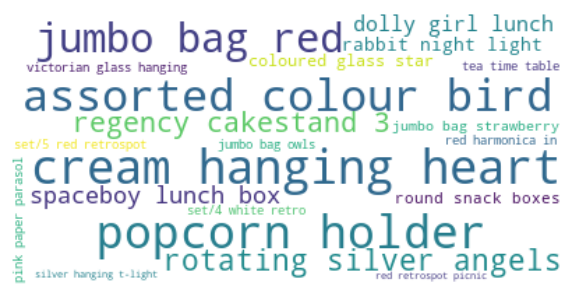

In [77]:
word_cloud(dict_counts) 

### Bar chart code and visualization

In [78]:
# Alternative visualization in Altair
words = list(dict_counts.keys())
counts = list(dict_counts.values())

def barh(df):   
    chart=alt.Chart(df).mark_bar(size=14,fontSize=16,color="#118497").encode(
            x=alt.X('Count:Q',title=country,scale=alt.Scale(domain=[0,110]),axis=None),
            y=alt.Y('Item:O',axis=alt.Axis(labelFontSize=10,
                                           labelPadding=5,
                                           title=None,
                                           grid=False),sort=words))
    text = alt.Chart(df).mark_text(size=10,dx=15,dy=0,fontWeight=200).encode(y=alt.Y('Item:O',sort=words),x=alt.X('Count:Q'),
                                                                            text=alt.Text('Count:O'))    
    return text+chart

def configuration_barh(chart,title,subtitle):
    
    chart_final = chart.configure_mark().properties(width=90,height=410,
        title=alt.TitleParams(text=title,fontSize=12,dy=-7)).configure_view(strokeWidth=0).configure_scale(bandPaddingInner=0.2)
    return chart_final


In [79]:
df = pd.DataFrame.from_dict(dict_counts,orient='index')
df.reset_index(inplace=True)
df.columns=["Item","Count"]
configuration_barh(barh(df),title="Figure 9: Count of Top Recommended Items", subtitle=" ")

alt.LayerChart(...)

In [80]:
# What percentage of the total counts 
sum_counts=sum(counts)
print("Top {} items sum of counts is {}, {}% of total recommended products".format(len(counts), sum_counts,int(sum_counts/(len(final)*5)*100)))

Top 21 items sum of counts is 691, 53% of total recommended products


# Conclusion:

**Where to play in 2012**  
Sales regression indicates a strong pool of 5 markets to focus on: France, Australia, Germany, The Netherlands and Switzerland.  These countries are already scaled, and the OLS regression is a simple technique to  capture their sales trend. Therefore, we recommend including these markets as a priority for our 2012 business plan. 

**How to win**  
Our similarity algorithm recommends 5 products for each of 259 key markets customers. We can recommend these products automatically online to our customers, or we could propose a shortlist of 24 items that represent 54% of all recommended products (710 recommendations out of a total of 1295).
On-line market research along to customer validation could also complement this recommendation approach.

**Beyond 2012**  
Once we maximize our key markets, our macro model suggests considering five countries as part of our strategic plan: Canada, Belgium, Austria, Korea and Italy . These countries are posting very limited sales today, but their macro data suggest potential.
This project is not static; as we gain more sales history and experience internationally, we will  be able to improve and update our models to reflect market and dynamics for additional business recommendations.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4cc0f255-20f9-4daf-8819-230d4245a6d1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>